### CAPTURE SATELLITE IMAGES FOR PRESENT PERIOD (2017 - 2022)

In [36]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date
import json
from json import JSONEncoder

Authentification auprès de Google Engine :

Cliquer sur le lien et suivre les instructions (avec compte google connecté) pour récupérer le token à copier-coller.

In [2]:
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())


Successfully saved authorization token.
NASADEM: NASA NASADEM Digital Elevation 30m


-----------

CLASS FOR EXCEPTIONS :

In [4]:
class NoImage(Exception):
    def __init__(self, nb_image):
        self.__nb_image = nb_image

    @property
    def nb_image(self):
        return self.nb_image

In [39]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (datetime, date)):
            return str(obj)
        return json.JSONEncoder.default(self, obj)

FUNCTIONS (FOR SENTINEL_2):

In [3]:
def NDVI(img): #repère la végétation tout simplement
    img = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return img

def EVI(img): #idem NDVI, plus fiable et fin en théorie
    img = ee.Image(img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': img.select('B8').divide(10000),
            'RED': img.select('B4').divide(10000),
            'BLUE': img.select('B2').divide(10000)
        })).rename(["evi"])
    
    return img

def NDMI(img): #repère la teneur en eau dans la végétation
    img = ee.Image(img.normalizedDifference(['B8', 'B11'])).rename(["ndmi"])
    #img = ee.Image(img.expression(
    #    '(NIR - SWITCH) / (SWITCH + NIR)', {
    #        'NIR': img.select('B8').divide(10000),
    #        'SWITCH': img.select('B11').divide(10000)
    #   })).rename(["ndmi"])
    return img

def NDWI(img): #teneur en d'eau en surface
    img = ee.Image(img.normalizedDifference(['B3', 'B8'])).rename(["ndwi"])
    #img = ee.Image(img.expression(
    #    '(GREEN - NIR) / (GREEN + NIR)', {
     #       'NIR': img.select('B8').divide(10000),
     #       'GREEN': img.select('B3').divide(10000)
     #   })).rename(["ndwi"])
    return img


def PSSra(img): #indice de pigmentation de la végétation
    img = ee.Image(img.expression(
        'NIRinf / RED', {
            'NIRinf': img.select('B7').divide(10000),
            'RED': img.select('B4').divide(10000),
        })).rename(["pssra"])
    
    return img

def MCARI(img): #Modified Chlorophyll Absorption Ratio Index
    img = ee.Image(img.expression(
        '((RED2 - RED) - 0.2 * (RED2 - GREEN)) * (RED2 - RED)', {
            'RED2': img.select('B5').divide(10000),
            'RED': img.select('B4').divide(10000),
            'GREEN': img.select('B3').divide(10000)
        })).rename(["mcari"])
    
    return img


def DSWI(img): # Disease Water Stress Index sensitive to stress due to water shortage and plant damage
    img = ee.Image(img.expression(
        '(NIR - GREEN) / (SWIR1 + RED)', {
            'NIR': img.select('B8').divide(10000),
            'RED': img.select('B4').divide(10000),
            'GREEN': img.select('B3').divide(10000),
            'SWIR1': img.select('B11').divide(10000),
        })).rename(["dswi"])
    
    return img


def B2(img):
    b2 = ee.Image(img.select(['B2'])).divide(10000).rename(["b2"])
    return b2

def B3(img):
    b3 = ee.Image(img.select(['B3'])).divide(10000).rename(["b3"])
    return b3

def B4(img):
    b4 = ee.Image(img.select(['B4'])).divide(10000).rename(["b4"])
    return b4

def B5(img):
    b5 = ee.Image(img.select(['B5'])).divide(10000).rename(["b5"])
    return b5

def B6(img):
    b6 = ee.Image(img.select(['B6'])).divide(10000).rename(["b6"])
    return b6

def B7(img):
    b7 = ee.Image(img.select(['B7'])).divide(10000).rename(["b7"])
    return b7

def B8(img):
    b8 = ee.Image(img.select(['B8'])).divide(10000).rename(["b8"])
    return b8

def B11(img):
    b11 = ee.Image(img.select(['B11'])).divide(10000).rename(["b11"])
    return b11


In [6]:
def collection_to_array(lat_loc, lon_loc, date_dep, date_fin):
    global dim_image, percentage_max_cloud_cover, Spectral_Band_init, Spectral_Functions
    pas_lat = dim_image/111120
    pas_lon = dim_image/111120
    area = ee.Geometry.BBox(lon_loc - pas_lon/2, lat_loc-pas_lat/2, lon_loc + pas_lon/2, lat_loc + pas_lat/2)

    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(area) \
                                      .filterDate(date_dep,date_fin) \
                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",percentage_max_cloud_cover)\
                                      .select(Spectral_Band_init)

    nb_images = collection.size().getInfo()
    print(f'{nb_images} images founded...')

    if nb_images == 0:
        raise NoImage(nb_images)

    im_dict = dict()

    
    for _, funct in enumerate(Spectral_Functions):
        myCollection  = collection.map(Spectral_Functions.get(funct))
        img = ee.Image(myCollection.mean()).rename(["result"])
        img = img.addBands(ee.Image.pixelLonLat())
        img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e8,\
                                        scale=1)
 
        data = np.array((ee.Array(img.get("result")).getInfo()))
        lats = np.array((ee.Array(img.get("latitude")).getInfo()))
        lons = np.array((ee.Array(img.get("longitude")).getInfo()))
        uniqueLats = np.unique(lats)
        uniqueLons = np.unique(lons)
        ncols = len(uniqueLons)
        nrows = len(uniqueLats)
        arr = np.zeros([nrows, ncols], np.float32)
        counter =0
        for y in range(0,len(arr),1):
            for x in range(0,len(arr[0]),1):
                if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                    counter+=1
                    arr[len(uniqueLats)-1-y,x] = data[counter]

        im_dict[f'{funct}'] = arr

        if funct==NDVI:
            im_dict[f'TNDVI'] = np.sqrt(arr) + 0.5
    
    return im_dict
    

    

-----------------------

IMPORT DATA :

In [7]:
data = pd.read_excel('./DataFrames/data_parcelles_with_gps.xlsx')

In [8]:
data_used = data[['PARCELLE','LAT', 'LON','DATE','LFI']]

--------------

USER PARAMETERS :

In [65]:
dim_image = 200 #mètres de côté

Choix de la campagne :

In [66]:
LFI = 'LFI1'

Paramètre de pourcentage de couverture nuageuse (filtre) :

In [67]:
percentage_max_cloud_cover = 5

Besoins en bandes spectrales (pour les fonctions) :

In [68]:
Spectral_Band_init = ['B2', 'B3', 'B4', 'B5', 'B7', 'B8', 'B11']

Bandes spectacles retenues (les bandes nécéssaires aux fonctions ci-dessous doivent se trouver dans la cellule juste au-dessus) :

Important : garder le format dictionnaire

In [69]:
Spectral_Functions = {'NDVI':NDVI, 'EVI':EVI}

Moitié d'ouverture temporelle (centrée au 30 juin) :

In [70]:
days = 7

La collection d'images se fera entre date - days et date + days...

------------

IMAGES CAPTURE :

In [76]:
data_lfi = data_used.loc[data_used['LFI']==LFI,:]
data_lfi['YEAR'] = data_lfi['DATE'].map(lambda d : d.year)
if LFI=='LFI1':
    data_lfi['YEAR'] = data_lfi['YEAR'].map(lambda d: 1984 if d==1983 else d)
data_lfi.YEAR.unique()

data_lfi['YEAR'] = 2021

nb_lines = len(data_lfi)
matrix_data = np.matrix(data_lfi)

Stock_images_list =dict()

for i in range(nb_lines):
    print(f'Parcelle {matrix_data.item(i, 0)}...')
    parc_dict=dict()
    date_image = datetime.datetime.strptime(str(matrix_data.item(i, 5)) + '-06-30', '%Y-%m-%d')
    date_dep = (date_image - datetime.timedelta(days=days))
    date_fin = (date_image + datetime.timedelta(days=days))
    date_dep_string = str(date_dep.year) + '-' + str(date_dep.month) + '-' + str(date_dep.day)
    date_fin_string = str(date_fin.year) + '-' + str(date_fin.month) + '-' + str(date_fin.day)
    lat_loc = matrix_data.item(i, 1)
    lon_loc = matrix_data.item(i, 2)

    try:
        dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
    except NoImage:
        date_dep -= datetime.timedelta(days=days)
        date_fin += datetime.timedelta(days=days)
        print(f'Zéro images for parcelle {matrix_data.item(i, 0)}... so we tried with a days open of {days*4} days...')
        try:
            dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
        except NoImage:
            date_dep -= datetime.timedelta(days=days)
            date_fin += datetime.timedelta(days=days)
            print(f'Zéro images for parcelle {matrix_data.item(i, 0)}... so we tried with a days open of {days*8} days...')
            try:
                dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
            except:
                print(f'Problem with parcelle {matrix_data.item(i, 0)}...')
                dict_images = np.nan
        except:
            print(f'Problem with parcelle {matrix_data.item(i, 0)}...')
            dict_images = np.nan
    except:
        print(f'Problem with parcelle {matrix_data.item(i, 0)}...')
        dict_images = np.nan


    parc_dict['PARCELLE'] = matrix_data.item(i, 0)
    parc_dict['LAT, LON'] = (lat_loc, lon_loc)
    parc_dict['DATE_INIT'] = str(matrix_data.item(i, 3))
    parc_dict['LFI'] = matrix_data.item(i, 4)
    parc_dict['DATE_IMAGE_SAT'] = str(date_image)
    parc_dict['IMAGES_SAT'] = dict_images
    Stock_images_list[f'{matrix_data.item(i, 0)}'] = parc_dict

list_json = json.dumps(Stock_images_list, cls=NumpyArrayEncoder)

with open(f"Images_SENTINEL_2_{LFI}.json", "w") as outfile:
    outfile.write(list_json)




Parcelle 51...
0 images founded...
Zéro images for parcelle 51... so we tried with a days open of 28 days...
1 images founded...
Parcelle 384...
0 images founded...
Zéro images for parcelle 384... so we tried with a days open of 28 days...
1 images founded...
Parcelle 1239...
0 images founded...
Zéro images for parcelle 1239... so we tried with a days open of 28 days...
2 images founded...


---------------

Test ouverture de fichier :

In [80]:
with open('sample.json', 'r') as openfile:
 
    json_object = json.load(openfile)

In [86]:
json_object['51'].get('DATE_IMAGE_SAT')

str

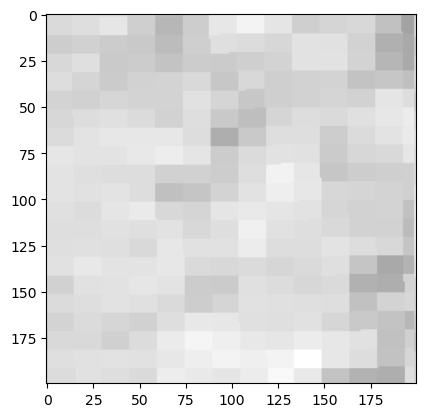

In [81]:
plt.imshow(json_object['51'].get('IMAGES_SAT').get('EVI'), 'gray')